In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import cv2
from collections import Counter, defaultdict
import itertools
import pickle
import tqdm
import glob
import tensorflow as tf
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

## Analysis

In [3]:
df = pd.DataFrame.from_csv('./train.csv')
df.tags = df.tags.apply(lambda x:x.split(' '))
df = pd.concat([df, df.tags.apply(pd.Series)], axis=1)

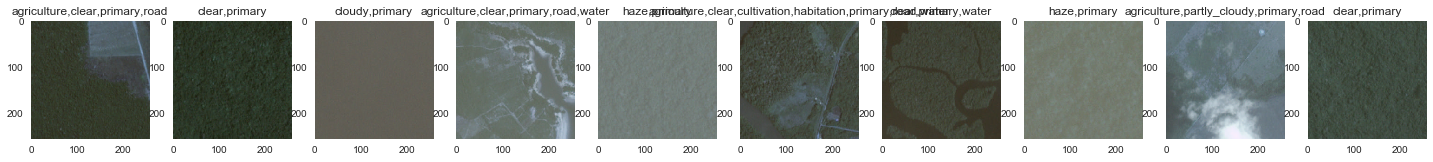

In [89]:
all_pictures = glob.glob('./train-jpg/*.jpg')
f, ax = plt.subplots(ncols=10, figsize=(25,30))
for i, k in enumerate(np.random.randint(len(df), size=10)):
    img = cv2.imread('./train-jpg/{}.jpg'.format(df.index[k]))
    ax[i].imshow(img)
    ax[i].set_title(','.join(df.iloc[k]["tags"]))
    ax[i].grid(False)

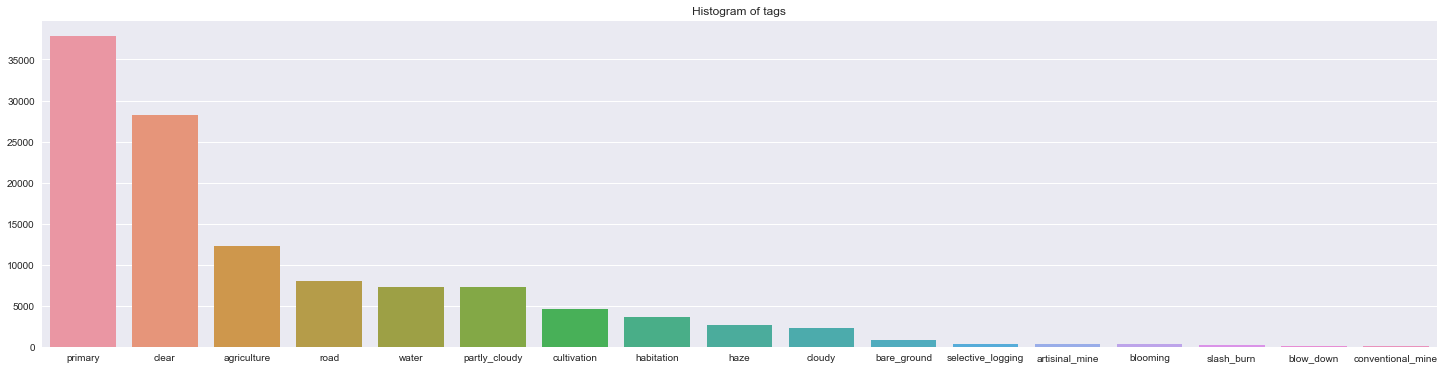

In [4]:
labels = list(df.tags)
counts = Counter(np.concatenate(labels))
plt.figure(figsize=(25,6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), order=sorted(counts, key=counts.get, reverse=True))
plt.title('Histogram of tags')

In [68]:
result = defaultdict(lambda: defaultdict(int))
for row in labels:
    counts = Counter(row)
    for key_from, key_to in itertools.permutations(counts, 2):
        result[key_from][key_to] += counts[key_from] * counts[key_to]

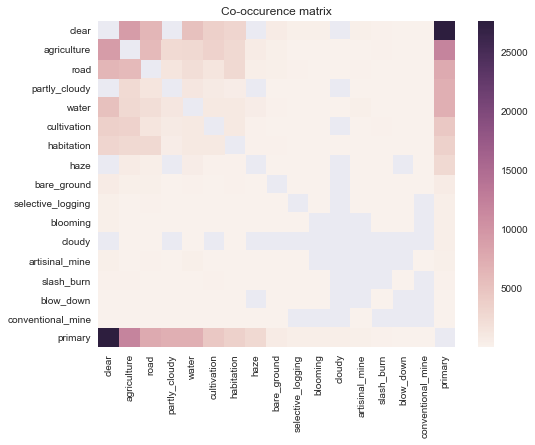

In [142]:
d = pd.DataFrame(result)
d.sort_values('primary', ascending=False, inplace=True)
d.sort_values('primary', ascending=False, inplace=True, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(d)
plt.title('Co-occurence matrix')

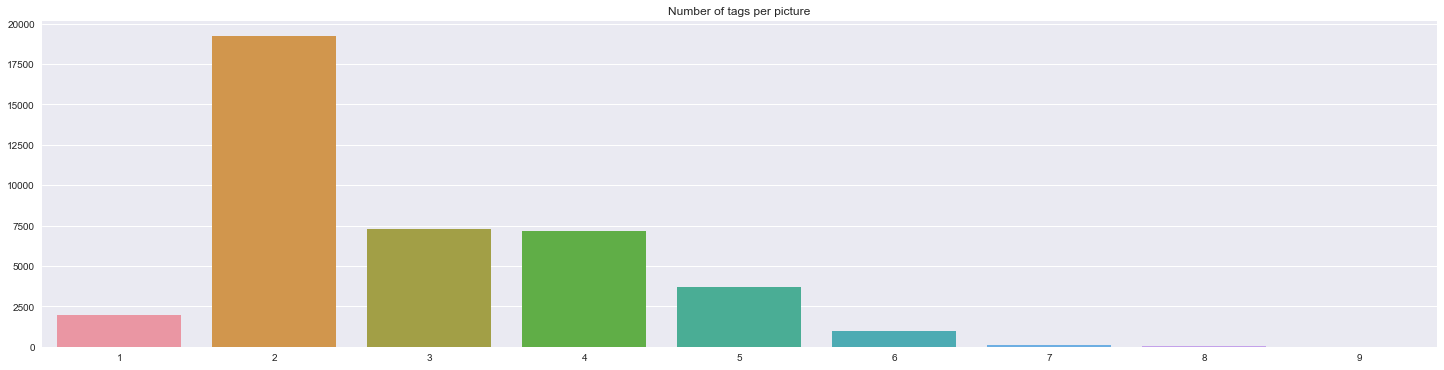

In [146]:
number_tags = {k+1:(sum(pd.isnull(df[k+1])) - sum(pd.isnull(df[k]))) for k in range(8)}
number_tags[9] = len(df[pd.notnull(df[8])])
plt.figure(figsize=(25,6))
sns.barplot(x=list(number_tags.keys()), y=list(number_tags.values()))#, order=sorted(number_tags, key=number_tags.get, reverse=True))
plt.title('Number of tags per picture')

## Learning

In [37]:
# %run ./train_keras.py

In [38]:
# %run ./predict_keras.py